# This is the classifier for the butterfly dataset

Below there is the machine learning workflow pipeline

Import packages and device selection

In [3]:
import os
import cv2
from atom import ATOMClassifier
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Dataset preprocessing

In [61]:
data = []
labels = []
path = '../data/images'
folder = os.listdir(path)
for file in folder:
    label = int(file[:3])
    img = cv2.imread(os.path.join(path, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    data.append(img)
    labels.append(label)

dict_1 = {1: 'Danaus_plexippus',
          2: 'Heliconius_charitonius',
          3: 'Heliconius_erato',
          4: 'Junonia_coenia',
          5: 'Lycaena_phlaeas',
          6: 'Nymphalis_antiopa',
          7: 'Papilio_cresphontes',
          8: 'Pieris_rapae',
          9: 'Vanessa_atalanta',
          10: 'Vanessa_cardui'}
list_labels = []
for i in labels:
    list_labels.append(dict_1[i])

In [59]:
print(list_labels[:10]) 

['Lycaena_phlaeas', 'Vanessa_cardui', 'Vanessa_cardui', 'Junonia_coenia', 'Lycaena_phlaeas', 'Nymphalis_antiopa', 'Papilio_cresphontes', 'Danaus_plexippus', 'Pieris_rapae', 'Nymphalis_antiopa']


display some samples

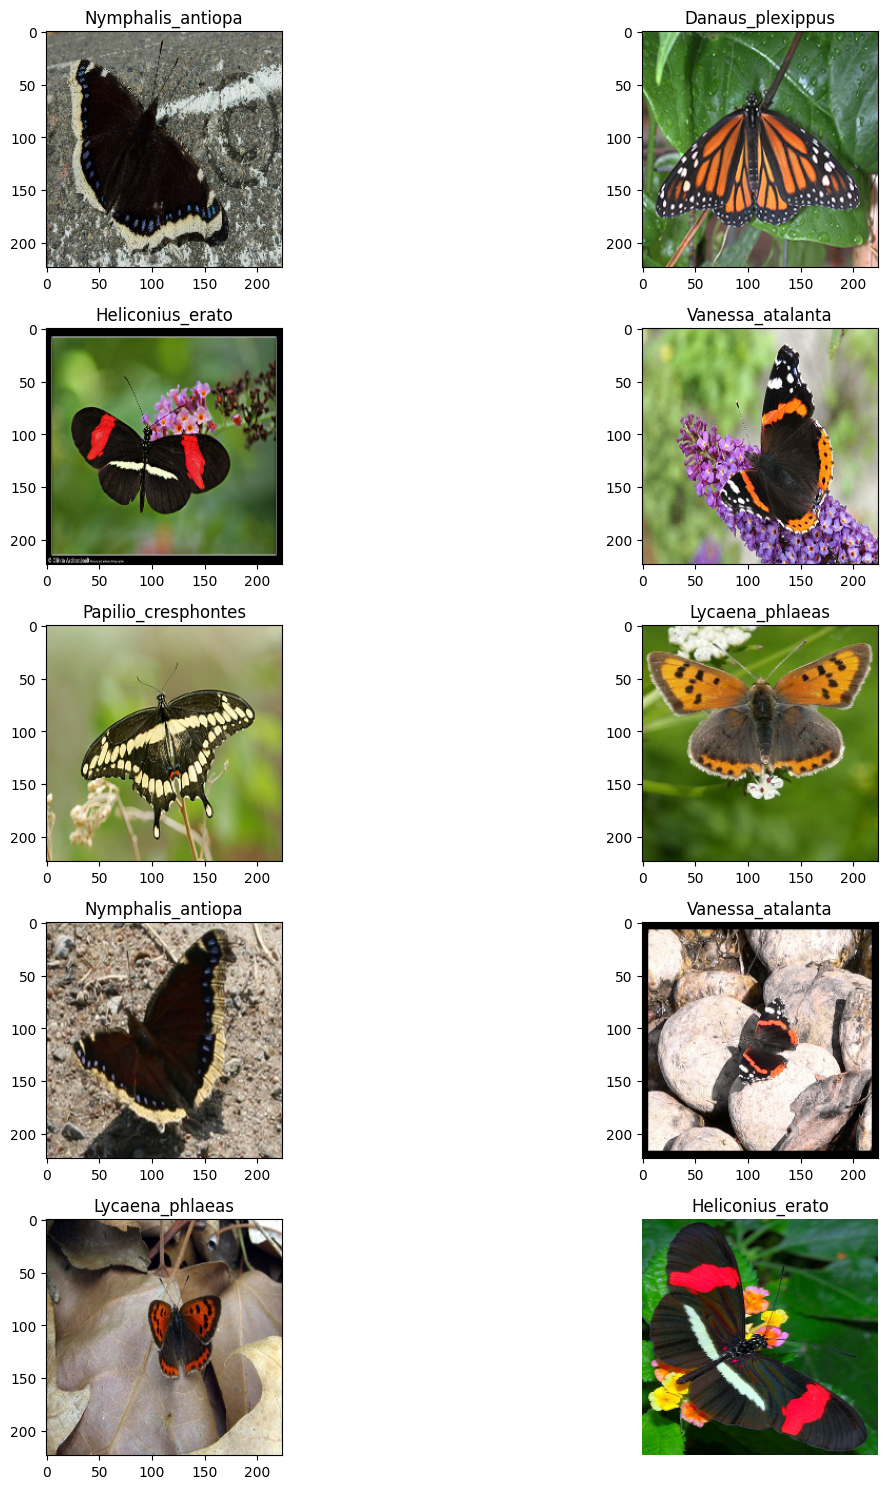

In [64]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=np.random.randint(0,len(labels))
        ax[i,j].imshow(data[l])
        ax[i,j].set_title(str(list_labels[l]))
plt.axis('off')        
plt.tight_layout()

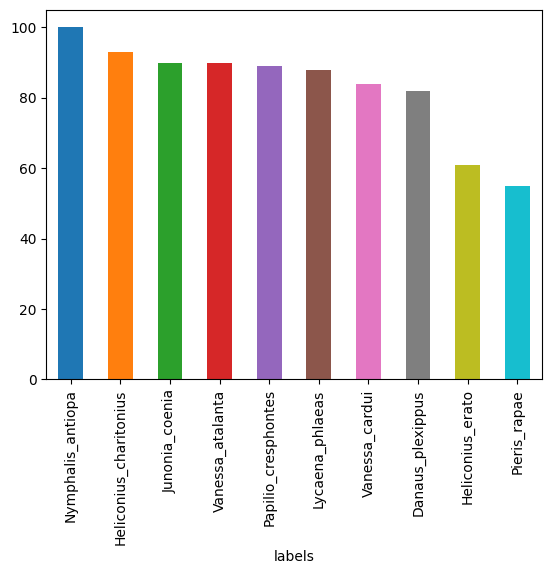

In [65]:
df = pd.DataFrame(list_labels, columns=['labels'])
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = [cycle[i % len(cycle)] for i in range(len(df['labels'].unique()))]
df['labels'].value_counts().plot(kind='bar', color=colors)
plt.show()

## Dataset Engineering